Created by: Sigrid Bom 

Date: 2024-12-07 

Latest change when and what:

Notes:

# 1. Data acquisition

In this script, the data will be acquired by getting the Bechdel labels of movies from the https://bechdeltest.com/ 

and the movie scripts from a kaggle dataset found here: https://www.kaggle.com/datasets/gufukuro/movie-scripts-corpus

In [2]:
# importing packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import kagglehub
import shutil
import seaborn as sns

## 1.1 Getting the Bechdel labels

In [3]:
# getting the Bechdel labels and movie titles using the API of the Bechdel website
labels = pd.read_json('http://bechdeltest.com/api/v1/getAllMovies')

For some reason, I can run the above perfectly fine in uCloud, but if I run it locally on my computer, I get an error. If you cannot get the labels, they can be found in the data folder. 

In [11]:
# if data cannot be acquired through the API, it can be loaded here:
#labels = pd.read_csv('data/bechdel_labels.csv')
labels.head()

,title,rating,imdbid,year,id
0,Passage de Venus,0,3155794,1874,9602
1,La Rosace Magique,0,14495706,1877,9804
2,Sallie Gardner at a Gallop,0,2221420,1878,9603
3,Le singe musicien,0,12592084,1878,9806
4,Athlete Swinging a Pick,0,7816420,1881,9816


In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10445 entries, 0 to 10446
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   10445 non-null  object
 1   rating  10445 non-null  int64 
 2   imdbid  10445 non-null  object
 3   year    10445 non-null  int64 
 4   id      10445 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 489.6+ KB


We have 10,447 entries (movies) and five different columns; id, year, rating, IMDB id and title

In [7]:
# remove rows without imdb id
labels = labels[~(labels['imdbid'].isna() | (labels['imdbid'] == ''))]

In [12]:

#labels['imdbid'] = labels['imdbid'].astype(float)

labels.head()

,title,rating,imdbid,year,id
0,Passage de Venus,0,3155794,1874,9602
1,La Rosace Magique,0,14495706,1877,9804
2,Sallie Gardner at a Gallop,0,2221420,1878,9603
3,Le singe musicien,0,12592084,1878,9806
4,Athlete Swinging a Pick,0,7816420,1881,9816


In [13]:
labels.info() # now we have 10,445

<class 'pandas.core.frame.DataFrame'>
Index: 10445 entries, 0 to 10446
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   10445 non-null  object
 1   rating  10445 non-null  int64 
 2   imdbid  10445 non-null  object
 3   year    10445 non-null  int64 
 4   id      10445 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 489.6+ KB


In [7]:
labels['rating']

0        0
1        0
2        0
3        0
4        0
        ..
10442    3
10443    1
10444    3
10445    2
10446    1
Name: rating, Length: 10445, dtype: int64

<Axes: xlabel='rating'>

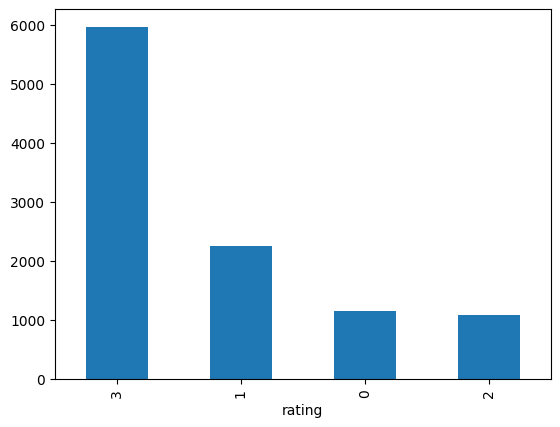

In [14]:
labels['rating'].value_counts().plot.bar()

The rating spans from 0-3. A rating of e.g., 1 means the movies passes 1 of the 3 Bechdel requirements. We want to recode that so that movies with a rating of 0-2 fail the Bechdel test (=0) and movies with a rating of 3 pass the Bechdel test (=1).

In [15]:
# Add a new column based on condition
labels['passed_bechdel'] = labels['rating'].apply(lambda x: 1 if x == 3 else 0)

In [16]:
labels.head()

,title,rating,imdbid,year,id,passed_bechdel
0,Passage de Venus,0,3155794,1874,9602,0
1,La Rosace Magique,0,14495706,1877,9804,0
2,Sallie Gardner at a Gallop,0,2221420,1878,9603,0
3,Le singe musicien,0,12592084,1878,9806,0
4,Athlete Swinging a Pick,0,7816420,1881,9816,0


<Axes: xlabel='passed_bechdel'>

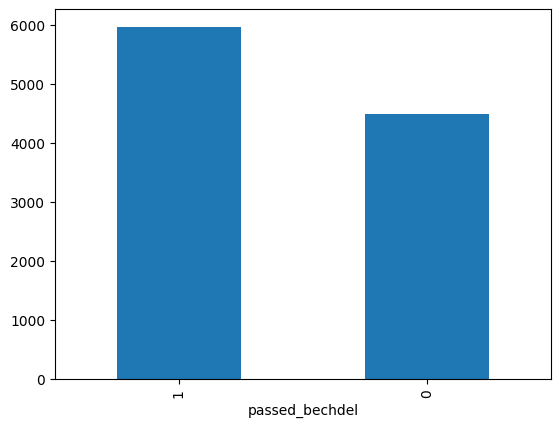

In [17]:
labels['passed_bechdel'].value_counts().plot.bar()

In [18]:
labels['passed_bechdel'].value_counts()

passed_bechdel
1    5964
0    4481
Name: count, dtype: int64

Pretty well balanced, 57% of the movies pass the Bechdel test.

Now I would like to make a list with all the movie titles, to use when matching the scripts from the scripts dataset later on.

In [ ]:
# fixing the .0 weird imdb label

# Remove '.0' from each string in the list
#labels['imdbid'] = [round(id) for id in labels['imdbid']]

# Print the cleaned list
#print(labels['imdbid'])
#labels.head()

0         3155794
1        14495706
2         2221420
3        12592084
4         7816420
           ...   
10442    27410895
10443     9218128
10444     1262426
10445    31807233
10446    24176060
Name: imdbid, Length: 10445, dtype: int64


,rating,title,imdbid,id,year,passed_bechdel
0,0,Passage de Venus,3155794,9602,1874,0
1,0,La Rosace Magique,14495706,9804,1877,0
2,0,Sallie Gardner at a Gallop,2221420,9603,1878,0
3,0,Le singe musicien,12592084,9806,1878,0
4,0,Athlete Swinging a Pick,7816420,9816,1881,0


In [19]:
labels_imdb_id = labels['imdbid'].to_list()
labels_imdb_id[0:20]

['3155794',
 '14495706',
 '2221420',
 '12592084',
 '7816420',
 '5459794',
 '8588366',
 '2075247',
 '8133192',
 '7411790',
 '7541160',
 '7754902',
 '8361552',
 '0392728',
 '1758563',
 '0343112',
 '3274100',
 '2116853',
 '0466876',
 '2116898']

## 1.2 Getting the movie scripts

Now I would like to go through a dataset from kaggle, which contains ~3,000 movie scripts

The dataset can be found here: https://www.kaggle.com/datasets/gufukuro/movie-scripts-corpus

Some of the following code has to be run locally on your computer ?? ucloud version

So, the pipeline is as follows:
1. __Download the dataset__ from kaggle either using the kagglehub API which I've done here (you need a kagglehub token, mine can be found in .kaggle) or download it manually and move it to the data folder.
2. __Get file names of movie scripts__ in downloaded data folder using a bash script 
3. __Find matching movies__ which are both in the Bechdel labels dataset and in the movie scripts folder using their imdb id 
4. __Copy the matched movie scripts to a separate folder__ caled matched_scripts using a bash script
5. __Filter the labels dataframe to only contain the matched movies__ 
6. __Append the moviescripts from the matched_scripts folder to the labels dataframe by matching imdb id__

in other words:
pipeline:
- the scripts are in individual txt files in a folder that I've downloaded from kaggle
- find out how many titles in the bechdel label dataset overlap with the movie scripts in the kaggle data set 
- make txt file of script names using bash 
- upload that file to ucloud (movie_scripts.txt)
- loop through movie_scripts file to find overlapping movie titles 
- upload only the overlapping scripts to ucloud and make one big dataframe w bechdel rating

In [15]:
# Download latest version
#local_path = '/Users/sigridagersnapbomnielsen/Documents/Python/2024_NLP/data'
saved_path = kagglehub.dataset_download("gufukuro/movie-scripts-corpus")

print("Path to dataset files:", saved_path)

100%|██████████| 657M/657M [00:20<00:00, 34.2MB/s] 

Extracting files...


Path to dataset files: /home/ucloud/.cache/kagglehub/datasets/gufukuro/movie-scripts-corpus/versions/1


In [ ]:
# Move the downloaded dataset to a custom directory
local_path = '/work/classes/NLP_exam/1_data_acquisition/data/' ## CHANGE THIS 
shutil.move(saved_path, local_path)

print("Dataset moved to:", local_path)

Dataset moved to: /work/LinusJoakimBackström#7558/NLP_exam/1_data_acquisition/data/


We now have the data in our data/1 folder. The folder is automatically called '1' because it is version 1 of the dataset. 

Next step is to get a list of the file names (the moviescripts). This is the most easily done using a bash script. I have created a bash script called "get_moviescript_titles.sh" which is run in the chunk below:

In [17]:
# run the bash script
! chmod +x get_moviescript_titles.sh
!./get_moviescript_titles.sh ./data/1/screenplay_data/data/raw_texts/raw_texts ./data/moviescript_titles.txt


List of .txt filenames has been saved to ./data/moviescript_titles.txt


In [20]:
# reading the txt file as a list

# Open the file and read it as a list
with open("data/moviescript_titles.txt", "r") as file:
    movie_scripts = file.readlines()

# Remove trailing newlines or whitespace characters
movie_scripts = [line.strip() for line in movie_scripts]

print(movie_scripts)
len(movie_scripts)

['10 Cloverfield Lane_1179933.txt', '10 Things I Hate About You_0147800.txt', '101 Days of 101 Dalmatians_0249328.txt', '12 Angry Men_0118528.txt', '12 Monkeys_0114746.txt', '12 Years a Slave_2024544.txt', '127 Hours_1542344.txt', '13 13 13_2991516.txt', '1408_0450385.txt', '1492 Conquest of Paradise_0103594.txt', '15 Minutes_0179626.txt', '16 Blocks_0450232.txt', '17 Again_0974661.txt', '1917_8579674.txt', '1976 l lection du Parti qu b cois_11327984.txt', '2 Broke Girls_1845307.txt', '2 Guns a Grenade a Pizza Guy_1871996.txt', '2001 A Space Road Odyssey_0288910.txt', '2010 The Odyssey Continues_0235153.txt', '2012_1190080.txt', '20th Century Women_4385888.txt', '21 Grams_0315733.txt', '21 Jump Street_1232829.txt', '22 July_7280898.txt', '25th Hour_0307901.txt', '28 Days Later_0289043.txt', '28 Days_0191754.txt', '28 Weeks Later_0463854.txt', '29th Street Highlander 2 The Quickening Billy Bathgate Year of the Gun_6099126.txt', '3 10 to Yuma_0381849.txt', '3 Godfathers_0040064.txt', '3 

2858

So, we have 2,858 movie scripts. Now we need to find the movie titles which are both in the bechdel dataset and in the moviescript dataset. 

In [21]:
#################### match by IMDB but pad Imdb id's with 0############# - works 
import re

# List to store matched pairs
matched_pairs = []

# Loop through IMDb IDs in labels_imdb_id
for imdb_id in labels_imdb_id:
    # Pad the IMDb ID to 7 digits (e.g., 5 -> 0000005)
    padded_id = str(imdb_id).zfill(7)
    
    # Check each movie script for a match
    for script in movie_scripts:
        # Use a regex to find the padded IMDb ID in the script filename
        if re.search(fr"_{padded_id}\.txt$", script):
            matched_pairs.append((imdb_id, script))
            break  # Stop searching for this IMDb ID once a match is found

# Print the results
print("Matched pairs:")
for pair in matched_pairs:
    print(pair)

Matched pairs:
('0013442', 'Nosferatu_0013442.txt')
('0016220', 'The Phantom of the Opera_0016220.txt')
('0015648', 'Battleship Potemkin_0015648.txt')
('0016039', 'The Lost World_0016039.txt')
('0017136', 'Metropolis_0017136.txt')
('0018037', 'The Jazz Singer_0018037.txt')
('0019254', 'The Passion of Joan of Arc_0019254.txt')
('0019777', 'The Cocoanuts_0019777.txt')
('0022054', 'The Last Flight_0022054.txt')
('0022958', 'Grand Hotel_0022958.txt')
('0022913', 'Freaks_0022913.txt')
('0023649', 'Vampyr_0023649.txt')
('0024216', 'King Kong_0024216.txt')
('0023969', 'Duck Soup_0023969.txt')
('0025316', 'It Happened One Night_0025316.txt')
('0027996', 'Mr Deeds Goes to Town_0027996.txt')
('0029162', 'Lost Horizon_0029162.txt')
('0029947', 'Bringing Up Baby_0029947.txt')
('0029870', 'Angels with Dirty Faces_0029870.txt')
('0032138', 'The Wizard of Oz_0032138.txt')
('0031381', 'Gone with the Wind_0031381.txt')
('0031971', 'Stagecoach_0031971.txt')
('0031725', 'Ninotchka_0031725.txt')
('0031679

In [22]:
len(matched_pairs) # 1,782 - more than before!

1781

In [21]:
# Save only the script file names from matched_pairs
# use this txt file to copy the matched scripts to another folder in bash 
matched_script_titles = [pair[1] for pair in matched_pairs]

# Write the script titles to a text file
with open("data/matched_script_titles.txt", "w") as f:
    for script in matched_script_titles:
        f.write(script + "\n")

print("Script titles saved to matched_script_titles.txt")

Script titles saved to matched_script_titles.txt


now we want to run a bash file to copy the wanted bash scripts to a another folder called matched_scripts - the bash file will make the folder 

In [22]:
# run the bash script: copy_matched_scripts.sh
! chmod +x copy_matched_scripts.sh
! ./copy_matched_scripts.sh

Copied Nosferatu_0013442.txt to matched_scripts/
Copied The Phantom of the Opera_0016220.txt to matched_scripts/
Copied Battleship Potemkin_0015648.txt to matched_scripts/
Copied The Lost World_0016039.txt to matched_scripts/
Copied Metropolis_0017136.txt to matched_scripts/
Copied The Jazz Singer_0018037.txt to matched_scripts/
Copied The Passion of Joan of Arc_0019254.txt to matched_scripts/
Copied The Cocoanuts_0019777.txt to matched_scripts/
Copied The Last Flight_0022054.txt to matched_scripts/
Copied Grand Hotel_0022958.txt to matched_scripts/
Copied Freaks_0022913.txt to matched_scripts/
Copied Vampyr_0023649.txt to matched_scripts/
Copied King Kong_0024216.txt to matched_scripts/
Copied Duck Soup_0023969.txt to matched_scripts/
Copied It Happened One Night_0025316.txt to matched_scripts/
Copied Mr Deeds Goes to Town_0027996.txt to matched_scripts/
Copied Lost Horizon_0029162.txt to matched_scripts/
Copied Bringing Up Baby_0029947.txt to matched_scripts/
Copied Angels with Dirty

### filtering the labels dataframe
to only contain the rows with the correct imdb ids

In [23]:
# filtering the dataframe to only contain the matched titles

# Extract matched titles from matched_pairs
matched_imdb_ids = [pair[0] for pair in matched_pairs]

# Filter the DataFrame to keep only rows where the title is in matched_titles
labels_filtered = labels[labels['imdbid'].isin(matched_imdb_ids)]

# Display the filtered DataFrame
print(len(labels_filtered))
labels_filtered.head()

1781


,title,rating,imdbid,year,id,passed_bechdel
162,"Nosferatu, eine Symphonie des Grauens",2,0013442,1922,1307,0
188,"Phantom of the Opera, The",2,0016220,1925,1305,0
189,Battleship Potemkin,0,0015648,1925,1308,0
194,"Lost World, The",2,0016039,1925,5514,0
204,Metropolis,1,0017136,1927,1267,0


### loading the scripts and appending them to the labels dataframe 

In [24]:
import os

# Define paths
scripts_folder = 'data/matched_scripts'  # The folder containing the script text files

# Create a dictionary mapping imdb_id to script file from matched_pairs
matched_scripts = {pair[0]: pair[1] for pair in matched_pairs}  # {imdb_id: script_filename}

# Function to read the script from a file with error handling for encoding issues
def read_script(imdb_id, folder=scripts_folder):
    script_file = matched_scripts.get(imdb_id)  # Get the script file name for the imdb_id
    if script_file:
        script_path = os.path.join(folder, script_file)  # Construct the correct path
        if os.path.exists(script_path):
            try:
                # Try reading with UTF-8 encoding first
                with open(script_path, 'r', encoding='utf-8') as file:
                    return file.read()  # Read and return the file content
            except UnicodeDecodeError:
                # If UTF-8 fails, try ISO-8859-1 (latin1)
                with open(script_path, 'r', encoding='ISO-8859-1') as file:
                    return file.read()  # Read and return the file content
        else:
            print(f"Script file {script_file} not found for IMDb ID {imdb_id}.")
            return ""
    return ""


# Add the script_filename column using .loc
labels_filtered.loc[:, 'script_filename'] = labels_filtered['imdbid'].apply(
    lambda imdb_id: matched_scripts.get(imdb_id, "")  # Get the script filename or "" if not found
)

# Add the script content column
labels_filtered.loc[:, 'script'] = labels_filtered['imdbid'].apply(
    lambda imdb_id: read_script(imdb_id) if imdb_id in matched_scripts else ""
)

#change the name 
labels_and_scripts = labels_filtered
# Display the updated DataFrame
labels_and_scripts.head()


/tmp/ipykernel_2719/2269167720.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_filtered.loc[:, 'script_filename'] = labels_filtered['imdbid'].apply(
/tmp/ipykernel_2719/2269167720.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_filtered.loc[:, 'script'] = labels_filtered['imdbid'].apply(


,title,rating,imdbid,year,id,passed_bechdel,script_filename,script
162,"Nosferatu, eine Symphonie des Grauens",2,0013442,1922,1307,0,Nosferatu_0013442.txt,\n\n 1922\n\n\n\n...
188,"Phantom of the Opera, The",2,0016220,1925,1305,0,The Phantom of the Opera_0016220.txt,The Phantom of the Opera\n\nTHE PHANTOM OF THE...
189,Battleship Potemkin,0,0015648,1925,1308,0,Battleship Potemkin_0015648.txt,Battleship Potemkin\n\nScenario and script by ...
194,"Lost World, The",2,0016039,1925,5514,0,The Lost World_0016039.txt,THE LOST WORLD\nJURASSIC PARK\n\nscreenplay by...
204,Metropolis,1,0017136,1927,1267,0,Metropolis_0017136.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n ...


In [25]:
labels_and_scripts.tail()

,title,rating,imdbid,year,id,passed_bechdel,script_filename,script
9708,Palm Springs,3,9484998,2020,9197,1,Palm Springs_9484998.txt,PALM SPRINGS\n\nWritten by\n\nAndy Siara\n\nSt...
9717,Tenet,1,6723592,2020,9252,0,Tenet_6723592.txt,TENET\n\nWritten by\n\nChristopher Nolan\n ORC...
9718,Bill &amp; Ted Face the Music,3,1086064,2020,9255,1,Bill Ted Face the Music_1086064.txt,Bill and Ted Face the Music\n\nby\nChris Mathe...
9854,Cherry,0,9130508,2021,9571,0,Cherry_9130508.txt,\n\n\n\nFADE IN:\n\n\nFADE IN:\nBLACK AND WHIT...
10025,Chaos Walking,3,2076822,2021,11264,1,Chaos Walking_2076822.txt,S.w.a.t.\n\nby\nGeorge Huang\n\nBased on th: T...


In [26]:
len(labels_and_scripts)

1781

In [30]:
labels_and_scripts = pd.read_csv('data/labels_and_scripts.csv')
labels_and_scripts.head()

,title,rating,imdbid,year,id,passed_bechdel,script_filename,script
0,"Nosferatu, eine Symphonie des Grauens",2,13442,1922,1307,0,Nosferatu_0013442.txt,\n\n 1922\n\n\n\n...
1,"Phantom of the Opera, The",2,16220,1925,1305,0,The Phantom of the Opera_0016220.txt,The Phantom of the Opera\n\nTHE PHANTOM OF THE...
2,Battleship Potemkin,0,15648,1925,1308,0,Battleship Potemkin_0015648.txt,Battleship Potemkin\n\nScenario and script by ...
3,"Lost World, The",2,16039,1925,5514,0,The Lost World_0016039.txt,THE LOST WORLD\nJURASSIC PARK\n\nscreenplay by...
4,Metropolis,1,17136,1927,1267,0,Metropolis_0017136.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n ...


In [19]:
# sanity checking the script column
# Get the indices of rows where the 'script' column has fewer than 5 characters
short_scripts_indices = labels_and_scripts[labels_and_scripts['script'].str.len() < 3000].index

# Print the indices
print(short_scripts_indices)


Index([21, 41, 50, 67, 79, 367, 982, 1480], dtype='int64')


In [21]:
labels_and_scripts.iloc[21]

title                          Stagecoach
rating                                  3
imdbid                              31971
year                                 1939
id                                    593
passed_bechdel                          1
script_filename    Stagecoach_0031971.txt
script                                ÿþ 
Name: 21, dtype: object

Some of the scripts look strange. Because it is a minor part of the dataset, we'll drop those rows. 

In [22]:
# Drop rows with short scripts from the DataFrame
labels_and_scripts = labels_and_scripts.drop(index=short_scripts_indices)

# Print the updated DataFrame
print(len(labels_and_scripts))

1773


In [ ]:
# save as csv
#labels_and_scripts.to_csv("data/labels_and_scripts.csv", index = False)

passed_bechdel
1    892
0    881
Name: count, dtype: int64

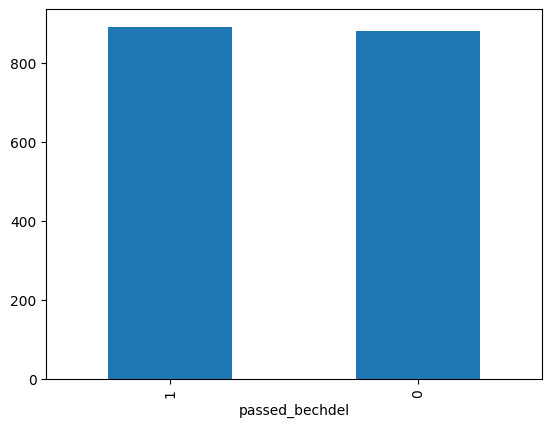

In [25]:
# checking the balance of bechdel test
labels_and_scripts['passed_bechdel'].value_counts().plot.bar()
labels_and_scripts['passed_bechdel'].value_counts() # what a balance :-) 

In [31]:
print(labels_and_scripts.iloc[1]['script'])

The Phantom of the Opera

THE PHANTOM OF THE OPERA

(The following foreword is to be presented on a moving scroll that
moves up)

FOREWORD
Dear patrons of the Silent Drama ...
In this present era of discovery and invention
Spiritualism and other psychic phenomena are scoffed
at by the masses in general. Therefore, we ask you
to bear with us while we unfold for your entertain-
ment, the story of the "Opera Ghost" which really
did exist according to the memoirs of the late M.
Faure, Chief of the Paris Secret Police, whose
weird tale of a criminal investigation which lead
him to an opaque veil that cloaked the supernatural
now lies in the archives of the National Academy
of Music in the French Capitol.

FADE OUT

1. FADE IN
CLOSE SHOT on a volume which rests on a rich
velvet table scarf-- on the book is the title in
French --MEMOIRES OF M. FAURE, CHIEF OF THE PARIS
SECRET POLICE. As the French letters dissolve into
English and we play long enough to identify, a
hand enters scene and opens

In [26]:
# checking
labels_and_scripts[21:30]

,title,rating,imdbid,year,id,passed_bechdel,script_filename,script
22,Ninotchka,3,31725,1939,1259,1,Ninotchka_0031725.txt,\n\n\n ...
23,Mr. Smith Goes to Washington,2,31679,1939,5946,0,Mr Smith Goes to Washington_0031679.txt,"""MR. SMITH GOES ..."
24,Only Angels Have Wings,2,31762,1939,10880,0,Only Angels Have Wings_0031762.txt,\n\nOnly Angel's Have Wings\n \n\n(O\n\nCS\n...
25,Rebecca,3,32976,1940,618,1,Rebecca_0032976.txt,REBECCA\n\nI\nLast night I dreamt I went to Ma...
26,"Grapes of Wrath, The",3,32551,1940,1387,1,The Grapes of Wrath_0032551.txt,\n\n\n\n<!--\n\nif (window!= top)\n\ntop.locat...
27,His Girl Friday,3,32599,1940,3033,1,His Girl Friday_0032599.txt,"\n\n\n ""HIS..."
28,"Maltese Falcon, The",1,33870,1941,1230,0,The Maltese Falcon_0033870.txt,\n\n= FALCON #\n\n3S:\n\nLE.\n\nTHE KA.\n\n ...
29,Citizen Kane,1,33467,1941,1266,0,Citizen Kane_0033467.txt,\n Citizen Ka...
30,Meet John Doe,3,33891,1941,3717,1,Meet John Doe_0033891.txt,\n \n ...


# Plotting time!

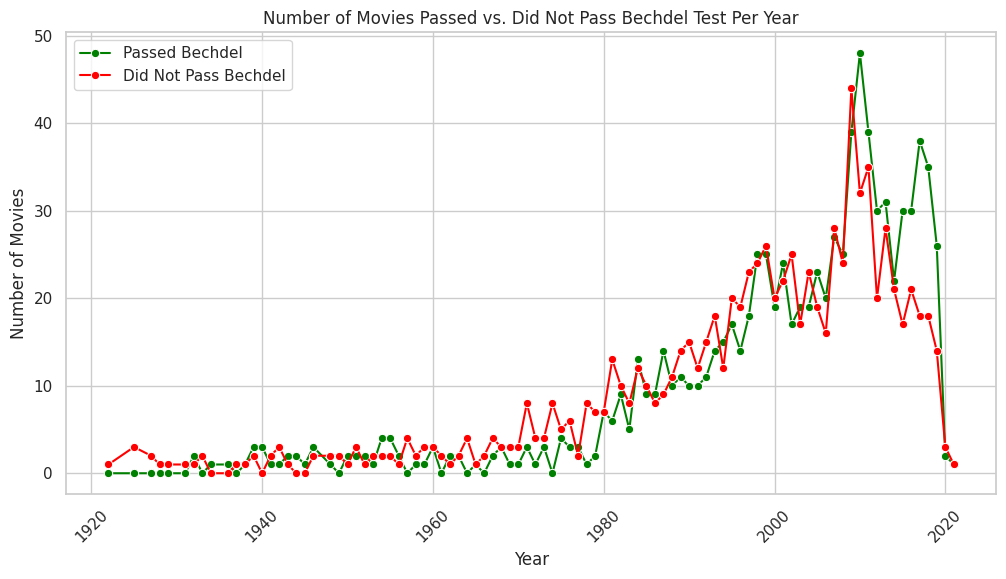

In [27]:


# Assuming your DataFrame is called labels_and_scripts
# Group by 'year' and sum the 'passed_bechdel' values
yearly_passed = labels_and_scripts.groupby('year')['passed_bechdel'].sum().reset_index()

# Calculate the total number of movies per year (assuming a binary 'passed_bechdel' value)
yearly_total = labels_and_scripts.groupby('year').size().reset_index(name='total_movies')

# Calculate the number of movies that didn't pass the Bechdel test
yearly_passed['did_not_pass'] = yearly_total['total_movies'] - yearly_passed['passed_bechdel']

# Set the plot style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the sum of 'passed_bechdel' for each year
sns.lineplot(data=yearly_passed, x='year', y='passed_bechdel', color='green', marker='o', label='Passed Bechdel')
# Plot the number of movies that did not pass the Bechdel test
sns.lineplot(data=yearly_passed, x='year', y='did_not_pass', color='red', marker='o', label='Did Not Pass Bechdel')

# Customize labels and title
plt.title('Number of Movies Passed vs. Did Not Pass Bechdel Test Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.show()


<Figure size 1200x600 with 0 Axes>

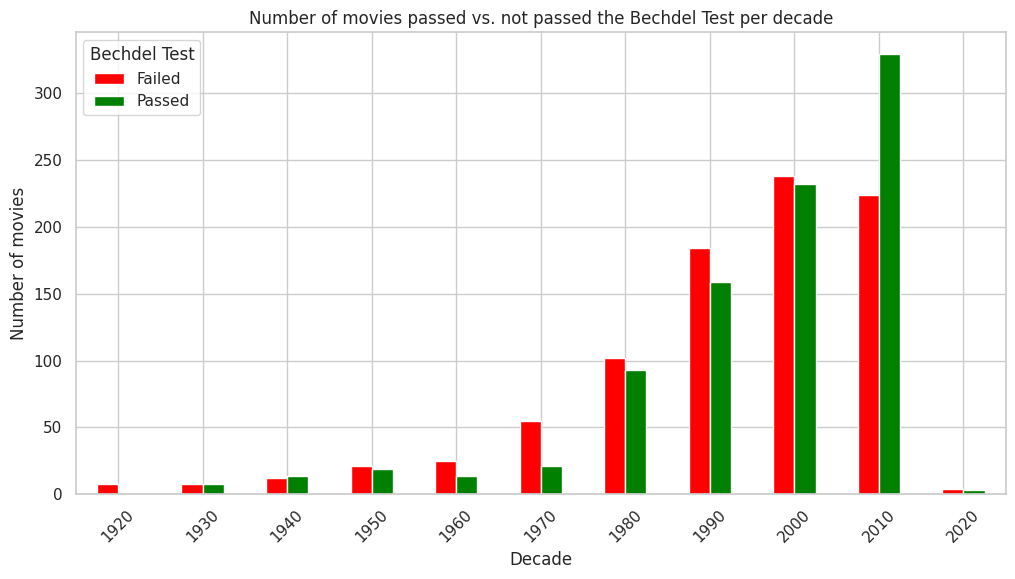

In [ ]:
# Create a new column 'decade' by flooring the 'year' to the nearest decade (e.g., 1902 becomes 1900)
labels_and_scripts['decade'] = (labels_and_scripts['year'] // 10) * 10

# Group by 'decade' and count the occurrences of 'passed_bechdel' for each decade
yearly_counts = labels_and_scripts.groupby(['decade', 'passed_bechdel']).size().unstack(fill_value=0).reset_index()

# Set the plot style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the bar chart for the binned data (stacked=False so passed and not passed are side by side)
yearly_counts.plot(x='decade', kind='bar', stacked=False, color=['red', 'green'], figsize=(12, 6))

# Customize labels and title
plt.title('Number of movies passed vs. not passed the Bechdel Test per decade')
plt.xlabel('Decade')
plt.ylabel('Number of movies')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Customize the legend labels
plt.legend(labels=['Failed', 'Passed'], title="Bechdel Test", loc='upper left')

# Save the plot as a JPEG file
#plt.savefig('../figures/bechdel_movies_per_year.jpeg', format='jpeg', dpi=300)  # Save the plot as a JPEG with 300 dpi

# Show the plot
plt.show()

/tmp/ipykernel_5358/1049450479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_and_scripts['5_year_bin'] = (labels_and_scripts['year'] // 5) * 5


<Figure size 1200x600 with 0 Axes>

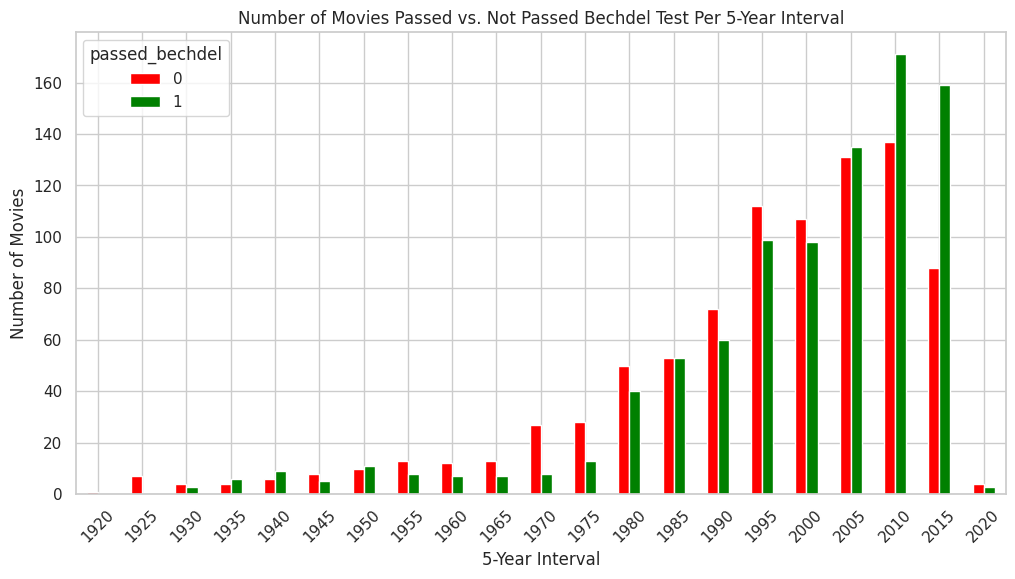

In [31]:
###### five-year interval plot
# Create a new column '5_year_bin' by flooring the 'year' to the nearest 5 years (e.g., 1902 becomes 1900)
labels_and_scripts['5_year_bin'] = (labels_and_scripts['year'] // 5) * 5

# Group by '5_year_bin' and count the occurrences of 'passed_bechdel' for each 5-year interval
yearly_counts = labels_and_scripts.groupby(['5_year_bin', 'passed_bechdel']).size().unstack(fill_value=0).reset_index()

# Set the plot style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the bar chart for the binned data (stacked=False so passed and not passed are side by side)
yearly_counts.plot(x='5_year_bin', kind='bar', stacked=False, color=['red', 'green'], figsize=(12, 6))

# Customize labels and title
plt.title('Number of Movies Passed vs. Not Passed Bechdel Test Per 5-Year Interval')
plt.xlabel('5-Year Interval')
plt.ylabel('Number of Movies')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

check out globglob??